In [6]:
from google.cloud import bigquery
from google.cloud.bigquery import dbapi
import os
import pandas as pd
import sys
#import yaml
import matplotlib.pyplot as plt

### Set environment variables to point to your GCP BQ credentials, and set your google project
For ease you can put this in your .bash_profile, or have it automatically set whenever you activate your [healthrex_ml environment](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#macos-and-linux)

In [2]:
client = bigquery.Client("som-nero-phi-jonc101"); # Alternatively, set GOOGLE_CLOUD_PROJECT environment variable
conn = dbapi.connect(client)
cursor = conn.cursor()

/sailhome/jyx/anaconda3/envs/jc/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# CBC 20k

In [3]:
suid='jyx' # your sunet id
EXPERIMENT_NAME = f"20230203_baseline_{suid}"
RUN_NAME = "baseline_cbc_models"


In [6]:
from healthrex_ml.cohorts.cohort import CohortBuilder
class CBCWithDifferentialCohortWithValue(CohortBuilder):
    """
    Defines a cohort and labels (result values) for CBC with differential models
    """

    def __init__(self, client, dataset_name, table_name,
                 working_project_id='mining-clinical-decisions', sample_size=20000):
        """
        Initializes dataset_name and table_name for where cohort table will be
        saved on bigquery
        """
        super().__init__(client, dataset_name,
              table_name, working_project_id)
        self.sample_size = sample_size

    def __call__(self):
        """
        Function that constructs a cohort table for predicting cbc with
        differential results. Done with SQL logic where possible
        """
        query = f"""
        CREATE OR REPLACE TABLE 
        {self.project_id}.{self.dataset_name}.{self.table_name}
        AS (
        WITH cbcd_lab_results as (
        SELECT DISTINCT
            anon_id,
            order_id_coded,
            order_time_utc as index_time,
            ordering_mode,
            base_name,
            ord_num_value label
        FROM 
            som-nero-phi-jonc101.shc_core_2021.lab_result
        WHERE 
            # Note no inpatient results where proc code was LABCBCD
            UPPER(group_lab_name) = 'CBC WITH DIFFERENTIAL'
        AND
            ((base_name='HCT' AND reference_unit='%') 
            OR (base_name='HGB' AND reference_unit='g/dL') 
            OR (base_name='PLT' AND reference_unit IN ('K/uL', 'x10E3/uL', 'Thousand/uL')) 
            OR (base_name='WBC' AND reference_unit IN ('K/uL', 'x10E3/uL', 'Thousand/uL')))
        AND 
            EXTRACT(YEAR FROM order_time_utc) BETWEEN 2015 and 2021
        AND
            ord_num_value IS NOT NULL
        ),
        # Pivot lab result to wide
        cohort_wide as (
            SELECT 
                * 
            FROM 
                cbcd_lab_results
            PIVOT (
                MAX(label) as label -- should be max of one value or no value 
                FOR base_name in ('WBC', 'PLT', 'HCT', 'HGB')
            )
            WHERE 
                -- only keep labs where all three components result
                label_WBC is not NULL AND
                label_PLT is not NULL AND
                label_HCT is not NULL AND
                label_HGB is not NULL
        )
        
        SELECT 
            anon_id, order_id_coded as observation_id, index_time, 
            ordering_mode, label_WBC, label_PLT, label_HCT, label_HGB
        FROM 
            (SELECT *,
                ROW_NUMBER() OVER  (PARTITION BY EXTRACT(YEAR FROM index_time)
                                    ORDER BY RAND()) 
                        AS seqnum
            FROM cohort_wide 
            ) 
        WHERE
            seqnum <= {self.sample_size}
        )
        
        """
        query_job = self.client.query(query)
        query_job.result()

In [7]:
#from healthrex_ml.cohorts import CBCWithDifferentialCohort 
cbc_cohort = CBCWithDifferentialCohortWithValue(
    client=client,
    dataset_name='jyx_db',
    working_project_id='mining-clinical-decisions',
    table_name=f"{EXPERIMENT_NAME}_{RUN_NAME}_20kcohort",
    sample_size=20000
)
cbc_cohort()

dd = pd.read_gbq(f'SELECT * FROM mining-clinical-decisions.jyx_db.{EXPERIMENT_NAME}_{RUN_NAME}_20kcohort', project_id='mining-clinical-decisions', progress_bar_type='tqdm')

/sailhome/jyx/anaconda3/envs/jc/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [10]:
print(len(dd))
dd.head()


140000


,anon_id,observation_id,index_time,ordering_mode,label_WBC,label_PLT,label_HCT,label_HGB
0,JC2480738,704234697.000000000,2020-12-26 13:24:00+00:00,Inpatient,10.800000000,218.000000000,19.800000000,6.600000000
1,JC2857067,665258534.000000000,2020-05-20 09:48:00+00:00,Inpatient,10.800000000,136.000000000,19.800000000,6.600000000
2,JC2142419,549330186.000000000,2017-12-30 08:41:00+00:00,Inpatient,3.900000000,127.000000000,19.800000000,6.600000000
3,JC3216346,741819782.000000000,2021-08-08 11:54:00+00:00,Inpatient,3.500000000,11.000000000,19.800000000,6.600000000
4,JC2770962,582110982.000000000,2018-12-04 13:10:00+00:00,Inpatient,5.100000000,19.000000000,19.800000000,6.600000000


In [11]:
dd.to_pickle('CBC_20k_uncleaned.pkl')

In [24]:
dd2 = dd[(dd['label_WBC']<5e6) & (dd['label_HCT']<=100)] #Work this out for data cleaning

(array([1.34136e+05, 4.41400e+03, 4.77000e+02, 1.57000e+02, 5.70000e+01,
        4.60000e+01, 2.90000e+01, 2.10000e+01, 2.00000e+01, 1.00000e+01,
        1.70000e+01, 1.00000e+01, 5.00000e+00, 4.00000e+00, 5.00000e+00,
        1.00000e+00, 5.00000e+00, 5.00000e+00, 1.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([1.00000000e-01, 1.79166667e+01, 3.57333333e+01, 5.35500000e+01,
        7.13666667e+01, 8.91833333e+01, 1.07000000e+02, 1.24816667e+02,
        1.42633333e+02, 1.60450000e+02, 1.78266667e+02, 1.96083333e+02,
        2.13900000e+02, 2.31716667e+02, 2.49533333e+02, 2.67350000e+02,
        2.85166667e+02, 3.02983333e+02, 3.20800000e+02, 3.38616667e+02,
        3.56433333e+02, 3.74250000e+02, 3.92066667e+02, 4.09883333e+02,
        4.27700000e+02, 4.45516667e+02, 4.63333333e+02, 4.81150000e+02,
        4.98966667e+02, 5.16783333e+02, 5.34600000e+02])

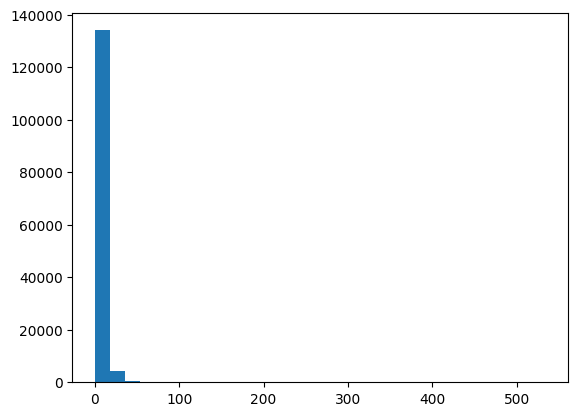

In [22]:
plt.hist(dd2['label_WBC'], bins=30)

In [41]:
from healthrex_ml.extractors.starr_extractors import add_create_or_append_logic
class PatientProblemGroupExtractor():
    """
    Defines logic to extract diagnoses on the patient's problem list
    """

    def __init__(self, cohort_table_id, feature_table_id,
                 project_id='som-nero-phi-jonc101', dataset='shc_core_2021'):
        """
        Args:
            cohort_table: name of cohort table -- used to join to features
            project_id: name of project you are extracting data from
            dataset: name of dataset you are extracting data from
        """
        self.cohort_table_id = cohort_table_id
        self.feature_table_id = feature_table_id
        self.client = bigquery.Client()
        self.project_id = project_id
        self.dataset = dataset

    def __call__(self):
        """
        Executes queries and returns all 
        """
        query = f"""
        SELECT
            labels.observation_id,
            labels.index_time,
            '{self.__class__.__name__}' as feature_type,
            CAST(dx.start_date_utc as TIMESTAMP) as feature_time,
            GENERATE_UUID() as feature_id,
            ccsr.CCSR_CATEGORY_1 as feature,
            1 value
        FROM
            ({self.cohort_table_id}
            labels
        LEFT JOIN
            {self.project_id}.{self.dataset}.diagnosis dx
        ON
            labels.anon_id = dx.anon_id)
        LEFT JOIN 
            mining-clinical-decisions.mapdata.ahrq_ccsr_diagnosis ccsr
        ON
            dx.icd10 = ccsr.icd10
        WHERE 
            CAST(dx.start_date_utc as TIMESTAMP) < labels.index_time
        AND
            source = 2 --problem list only
        """
        query = add_create_or_append_logic(query, self.feature_table_id)
        query_job = self.client.query(query)
        query_job.result()

In [42]:
class MedicationGroupExtractor():
    """
    Defines logic to extract medication orders
    """

    def __init__(self, cohort_table_id, feature_table_id,
                 look_back_days=28, project_id='som-nero-phi-jonc101',
                 dataset='shc_core_2021'):
        """
        Args:
            cohort_table: name of cohort table -- used to join to features
            project_id: name of project you are extracting data from
            dataset: name of dataset you are extracting data from
        """
        self.cohort_table_id = cohort_table_id
        self.look_back_days = look_back_days
        self.project_id = project_id
        self.dataset = dataset
        self.feature_table_id = feature_table_id
        self.client = bigquery.Client()

    def __call__(self):
        """
        Executes queries and returns all 
        """
        query = f"""
        SELECT DISTINCT
            labels.observation_id,
            labels.index_time,
            '{self.__class__.__name__}' as feature_type,
            meds.order_inst_utc as feature_time,
            CAST(meds.order_med_id_coded as STRING) as feature_id,
            meds.thera_class_abbr as feature,
            1 as value
        FROM
            {self.cohort_table_id}
            labels
        LEFT JOIN
            {self.project_id}.{self.dataset}.order_med meds
        ON
            labels.anon_id = meds.anon_id
        WHERE 
            CAST(meds.order_inst_utc as TIMESTAMP) < labels.index_time
        AND
            TIMESTAMP_ADD(meds.order_inst_utc,
                          INTERVAL 24*{self.look_back_days} HOUR)
                          >= labels.index_time
        """
        query = add_create_or_append_logic(query, self.feature_table_id)
        query_job = self.client.query(query)
        query_job.result()


In [43]:
from healthrex_ml.extractors import (
    AgeExtractor,
    RaceExtractor,
    SexExtractor,
    EthnicityExtractor,
    ProcedureExtractor,
    PatientProblemExtractor,
    MedicationExtractor,
    LabOrderExtractor,
    LabResultBinsExtractor,
    FlowsheetBinsExtractor
)

USED_EXTRACTORS = [AgeExtractor,
    RaceExtractor,
    SexExtractor,
    EthnicityExtractor,
    PatientProblemGroupExtractor,
    MedicationGroupExtractor,
    LabOrderExtractor,
    LabResultBinsExtractor,
    FlowsheetBinsExtractor
]

cohort_table=f"{cbc_cohort.project_id}.{cbc_cohort.dataset_name}.{cbc_cohort.table_name}"
feature_table=f"{cbc_cohort.project_id}.{cbc_cohort.dataset_name}.{EXPERIMENT_NAME}_feature_matrix"
extractors = [
    ext(cohort_table_id=cohort_table, feature_table_id=feature_table)
    for ext in USED_EXTRACTORS
]

/sailhome/jyx/anaconda3/envs/jc/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/sailhome/jyx/anaconda3/envs/jc/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more informatio

In [44]:
feature_table

'mining-clinical-decisions.jyx_db.20230203_baseline_jyx_feature_matrix'

In [45]:
from healthrex_ml.featurizers import BagOfWordsFeaturizer

featurizer = BagOfWordsFeaturizer(
        cohort_table_id=cohort_table,
        feature_table_id=feature_table,
        extractors=extractors,
        outpath=f"./{EXPERIMENT_NAME}_artifacts",
        tfidf=True
)
featurizer()

/sailhome/jyx/anaconda3/envs/jc/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/sailhome/jyx/anaconda3/envs/jc/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more informatio

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
Feature matrix generated with 3743 features


## Training

In [3]:
suid='jyx' # your sunet id
EXPERIMENT_NAME = f"20230203_baseline_{suid}"
RUN_NAME = "baseline_cbc_models"

In [5]:
#New starting points
import numpy as np
from scipy.sparse import load_npz
X_train = load_npz(f"./{EXPERIMENT_NAME}_artifacts/train_features.npz")
print(X_train.shape)
X_test = load_npz(f"./{EXPERIMENT_NAME}_artifacts/test_features.npz")
print(X_test.shape)

(120000, 3743)
(20000, 3743)


In [7]:
Y_train = pd.read_csv(f"./{EXPERIMENT_NAME}_artifacts/train_labels.csv")
Y_test = pd.read_csv(f"./{EXPERIMENT_NAME}_artifacts/test_labels.csv")

In [8]:
Y_train.head()

,anon_id,observation_id,index_time,ordering_mode,label_WBC,label_PLT,label_HCT,label_HGB
0,JC1606256,453315255.0,2015-01-10 14:49:00+00:00,Inpatient,1.8,118.0,28.2,9.8
1,JC1702318,453966136.0,2015-01-18 00:45:00+00:00,Inpatient,1.0,115.0,34.5,11.6
2,JC1606256,454073202.0,2015-01-21 16:23:00+00:00,Inpatient,1.7,90.0,23.7,8.2
3,JC2499977,454293963.0,2015-01-24 15:42:00+00:00,Inpatient,7.9,68.0,30.6,9.7
4,JC1500008,454487364.0,2015-01-15 17:53:00+00:00,Inpatient,8.1,44.0,27.2,9.6


119086


(array([33162., 62626., 16120.,  4259.,  1505.,   671.,   346.,   183.,
          127.,    87.]),
 array([ 0.1 ,  5.08, 10.06, 15.04, 20.02, 25.  , 29.98, 34.96, 39.94,
        44.92, 49.9 ]),
 <BarContainer object of 10 artists>)

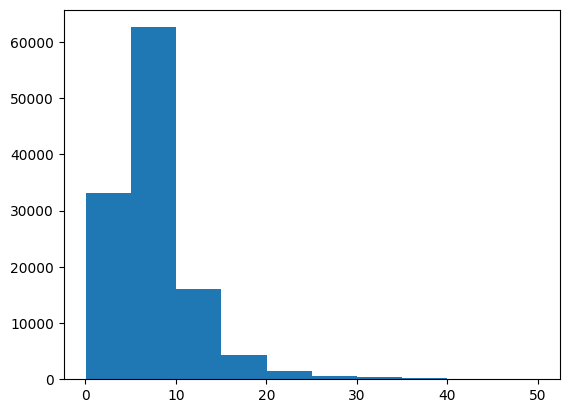

In [24]:
thres = 50
m = Y_train['label_WBC']<thres
y = Y_train[m]
print(len(y))
plt.hist(y['label_WBC'])

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(verbose=1).fit(X_train[m], Y_train['label_WBC'][m])


      Iter       Train Loss   Remaining Time 
         1          21.9441            7.00m
         2          20.9206            6.78m
         3          19.9631            6.66m
         4          19.2573            6.57m
         5          18.5913            6.48m
         6          18.0940            6.41m
         7          17.6317            6.33m
         8          17.2485            6.26m
         9          16.9187            6.18m
        10          16.6457            6.11m
        20          15.2264            5.43m
        30          14.6308            4.76m
        40          14.3069            4.09m


In [ ]:
mean_squared_error(Y_test['label_WBC'], est.predict(X_test))

In [ ]:
import pickle
with open('WBC_model.pkl', 'wb') as f:
    pickle.dump(est, f)

In [ ]:
class NGBoostTrainer():
    pass 

In [ ]:


from healthrex_ml.trainers import LightGBMTrainer

trainer = LightGBMTrainer(working_dir=f"./{RUN_NAME}_artifacts")
tasks = ['label_PLT', 'label_HCT', 'label_WBC', 'label_HGB']

for task in tasks:
    trainer(task)

# MCP cohort

In [6]:
from healthrex_ml.cohorts.cohort import CohortBuilder

class MetabolicComprehensiveCohortWithValue(CohortBuilder):
    """
    Defines a cohort and labels for metabolic comprehensive tasks
    """

    def __init__(self, client, dataset_name, table_name,
                 working_project_id='mining-clinical-decisions'):
        """
        Initializes dataset_name and table_name for where cohort table will be
        saved on bigquery
        """
        super().__init__(client,
              dataset_name, table_name, working_project_id)

    def __call__(self):
        """
        Function that constructs a cohort table for predicting cbc with
        differential results. Done with SQL logic where possible
        """
        query = f"""
        CREATE OR REPLACE TABLE 
        {self.project_id}.{self.dataset_name}.{self.table_name}
        AS (
        WITH metabolic_comp as (
        SELECT DISTINCT
            anon_id,
            order_id_coded,
            order_time_utc as index_time,
            ordering_mode,
            base_name,
            ord_num_value label
        FROM 
            som-nero-phi-jonc101.shc_core_2021.lab_result
        WHERE 
            # Note no inpatient results where proc code was LABCBCD
            group_lab_name = 'Metabolic Panel, Comprehensive'
        AND
            ((base_name='NA' AND reference_unit IN ('mmol/L', 'mmol/l'))
            OR (base_name='K' AND reference_unit IN ('mmol/L', 'mmol/l'))
            OR (base_name='CO2' AND reference_unit IN ('mmol/L', 'mmol/l'))
            OR (base_name='BUN' AND reference_unit IN ('mg/dL', 'mg/dl'))
            OR (base_name='CR' AND reference_unit IN ('mg/dL', 'mg/dl'))
            OR (base_name='CA' AND reference_unit IN ('mg/dL', 'mg/dl'))
            OR (base_name='ALB' AND reference_unit IN ('g/dL', 'g/dl')))
        AND 
            EXTRACT(YEAR FROM order_time_utc) BETWEEN 2015 and 2021
        ),
        # Pivot lab result to wide
        cohort_wide as (
            SELECT 
                * 
            FROM 
                metabolic_comp
            PIVOT (
                MAX(label) as label -- should be max of one value or no value 
                FOR base_name in ('NA', 'K', 'CO2', 'BUN', 'CR', 'CA', 'ALB')
            )
            WHERE 
                -- only keep labs where all three components result
                label_NA is not NULL AND
                label_K is not NULL AND
                label_CO2 is not NULL AND
                label_BUN is not NULL AND
                label_CR is not NULL AND
                label_CA is not NULL AND
                label_ALB is not NULL
        )
        SELECT 
            anon_id, order_id_coded as observation_id, index_time, 
            ordering_mode, label_NA, label_K, label_CO2, label_BUN, label_CR,
            label_CA, label_ALB
        FROM 
            (SELECT *,
                ROW_NUMBER() OVER  (PARTITION BY EXTRACT(YEAR FROM index_time)
                                    ORDER BY RAND()) 
                        AS seqnum
            FROM cohort_wide 
            ) 
        )
        """
        query_job = self.client.query(query)
        query_job.result()

In [7]:
suid='jyx' # your sunet id
EXPERIMENT_NAME = f"20230201_baseline_{suid}"
RUN_NAME = "baseline_bmp_models"

In [9]:
bmp_cohort = MetabolicComprehensiveCohortWithValue(
    client=client,
    dataset_name='jyx_db',
    working_project_id='mining-clinical-decisions',
    table_name=f"{EXPERIMENT_NAME}_{RUN_NAME}_cohortnosampling"
)
bmp_cohort()

In [10]:
dd = pd.read_gbq(f'SELECT * FROM mining-clinical-decisions.jyx_db.{EXPERIMENT_NAME}_{RUN_NAME}_cohortnosampling', project_id='mining-clinical-decisions', progress_bar_type='tqdm')

/sailhome/jyx/anaconda3/envs/jc/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [11]:
dd.to_pickle('BMP_NoSampling_uncleaned.pkl')

In [14]:
dd.head()

,anon_id,observation_id,index_time,ordering_mode,label_NA,label_K,label_CO2,label_BUN,label_CR,label_CA,label_ALB
0,JC2961231,666128450.000000000,2020-06-16 10:51:00+00:00,Inpatient,156.000000000,1.600000000,14.000000000,16.000000000,1.130000000,8.800000000,3.400000000
1,JC2675104,563727413.000000000,2018-06-24 01:11:00+00:00,Inpatient,119.000000000,1.500000000,9999999.000000000,17.000000000,0.570000000,9.500000000,4.200000000
2,JC1255236,712934018.000000000,2021-02-25 04:36:00+00:00,Inpatient,131.000000000,2.100000000,20.000000000,6.000000000,0.540000000,7.500000000,2.100000000
3,JC2385563,617176887.000000000,2019-07-28 07:14:00+00:00,Outpatient,158.000000000,2.100000000,15.000000000,10.000000000,0.210000000,5.800000000,2.000000000
4,JC2237442,592843798.000000000,2019-03-06 18:47:00+00:00,Inpatient,143.000000000,2.100000000,19.000000000,13.000000000,0.460000000,5.300000000,1.900000000


In [4]:
from healthrex_ml.cohorts.cohort import CohortBuilder
class CBCWithDifferentialCohortWithValue(CohortBuilder):
    """
    Defines a cohort and labels (result values) for CBC with differential models
    """

    def __init__(self, client, dataset_name, table_name,
                 working_project_id='mining-clinical-decisions'):
        """
        Initializes dataset_name and table_name for where cohort table will be
        saved on bigquery
        """
        super().__init__(client, dataset_name,
              table_name, working_project_id)

    def __call__(self):
        """
        Function that constructs a cohort table for predicting cbc with
        differential results. Done with SQL logic where possible
        """
        query = f"""
        CREATE OR REPLACE TABLE 
        {self.project_id}.{self.dataset_name}.{self.table_name}
        AS (
        WITH cbcd_lab_results as (
        SELECT DISTINCT
            anon_id,
            order_id_coded,
            order_time_utc as index_time,
            ordering_mode,
            base_name,
            ord_num_value label
        FROM 
            som-nero-phi-jonc101.shc_core_2021.lab_result
        WHERE 
            # Note no inpatient results where proc code was LABCBCD
            UPPER(group_lab_name) = 'CBC WITH DIFFERENTIAL'
        AND
            ((base_name='HCT' AND reference_unit='%') 
            OR (base_name='HGB' AND reference_unit='g/dL') 
            OR (base_name='PLT' AND reference_unit IN ('K/uL', 'x10E3/uL', 'Thousand/uL')) 
            OR (base_name='WBC' AND reference_unit IN ('K/uL', 'x10E3/uL', 'Thousand/uL')))
        AND 
            EXTRACT(YEAR FROM order_time_utc) BETWEEN 2015 and 2021
        AND
            ord_num_value IS NOT NULL
        ),
        # Pivot lab result to wide
        cohort_wide as (
            SELECT 
                * 
            FROM 
                cbcd_lab_results
            PIVOT (
                MAX(label) as label -- should be max of one value or no value 
                FOR base_name in ('WBC', 'PLT', 'HCT', 'HGB')
            )
            WHERE 
                -- only keep labs where all three components result
                label_WBC is not NULL AND
                label_PLT is not NULL AND
                label_HCT is not NULL AND
                label_HGB is not NULL
        )
        ### 10000 observations randomly sampled per year from train set
        SELECT 
            anon_id, order_id_coded as observation_id, index_time, 
            ordering_mode, label_WBC, label_PLT, label_HCT, label_HGB
        FROM 
            (SELECT *,
                ROW_NUMBER() OVER  (PARTITION BY EXTRACT(YEAR FROM index_time)
                                    ORDER BY RAND()) 
                        AS seqnum
            FROM cohort_wide 
            ) 
        WHERE
            seqnum <= 2000
        )
        
        """
        query_job = self.client.query(query)
        query_job.result()
class CBCWithDifferentialCohortWithValueNoSampling(CohortBuilder):
    """
    Defines a cohort and labels (result values) for CBC with differential models
    """

    def __init__(self, client, dataset_name, table_name,
                 working_project_id='mining-clinical-decisions'):
        """
        Initializes dataset_name and table_name for where cohort table will be
        saved on bigquery
        """
        super().__init__(client, dataset_name,
              table_name, working_project_id)

    def __call__(self):
        """
        Function that constructs a cohort table for predicting cbc with
        differential results. Done with SQL logic where possible
        """
        query = f"""
        CREATE OR REPLACE TABLE 
        {self.project_id}.{self.dataset_name}.{self.table_name}
        AS (
        WITH cbcd_lab_results as (
        SELECT DISTINCT
            anon_id,
            order_id_coded,
            order_time_utc as index_time,
            ordering_mode,
            base_name,
            ord_num_value label
        FROM 
            som-nero-phi-jonc101.shc_core_2021.lab_result
        WHERE 
            # Note no inpatient results where proc code was LABCBCD
            UPPER(group_lab_name) = 'CBC WITH DIFFERENTIAL'
        AND
            ((base_name='HCT' AND reference_unit='%') 
            OR (base_name='HGB' AND reference_unit='g/dL') 
            OR (base_name='PLT' AND reference_unit IN ('K/uL', 'x10E3/uL', 'Thousand/uL')) 
            OR (base_name='WBC' AND reference_unit IN ('K/uL', 'x10E3/uL', 'Thousand/uL')))
        AND 
            EXTRACT(YEAR FROM order_time_utc) BETWEEN 2015 and 2021
        AND
            ord_num_value IS NOT NULL
        ),
        # Pivot lab result to wide
        cohort_wide as (
            SELECT 
                * 
            FROM 
                cbcd_lab_results
            PIVOT (
                MAX(label) as label -- should be max of one value or no value 
                FOR base_name in ('WBC', 'PLT', 'HCT', 'HGB')
            )
            WHERE 
                -- only keep labs where all three components result
                label_WBC is not NULL AND
                label_PLT is not NULL AND
                label_HCT is not NULL AND
                label_HGB is not NULL
        )
        ### 10000 observations randomly sampled per year from train set
        SELECT 
            anon_id, order_id_coded as observation_id, index_time, 
            ordering_mode, label_WBC, label_PLT, label_HCT, label_HGB
        FROM 
            (SELECT *,
                ROW_NUMBER() OVER  (PARTITION BY EXTRACT(YEAR FROM index_time)
                                    ORDER BY RAND()) 
                        AS seqnum
            FROM cohort_wide 
            )
        )
        
        """
        query_job = self.client.query(query)
        query_job.result()




In [5]:
#from healthrex_ml.cohorts import CBCWithDifferentialCohort 
cohort = CBCWithDifferentialCohortWithValue(
    client=client,
    dataset_name='jyx_db',
    working_project_id='mining-clinical-decisions',
    table_name=f"{EXPERIMENT_NAME}_{RUN_NAME}_cohort"
)
cohort()

In [9]:
cohort = CBCWithDifferentialCohortWithValueNoSampling(
    client=client,
    dataset_name='jyx_db',
    working_project_id='mining-clinical-decisions',
    table_name=f"{EXPERIMENT_NAME}_{RUN_NAME}_cohortnosampling"
)
cohort()

In [4]:
dd = pd.read_gbq(f'SELECT * FROM mining-clinical-decisions.jyx_db.{EXPERIMENT_NAME}_{RUN_NAME}_cohortnosampling', project_id='mining-clinical-decisions', progress_bar_type='tqdm_notebook')

/sailhome/jyx/anaconda3/envs/jc/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Downloading:   0%|          |

# Evaluate model performance on test set and dump 

Implementation of [BinaryEvaluator](https://github.com/HealthRex/healthrex_ml/blob/main/healthrex_ml/evaluators/evaluators.py#L21) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.79s/it]


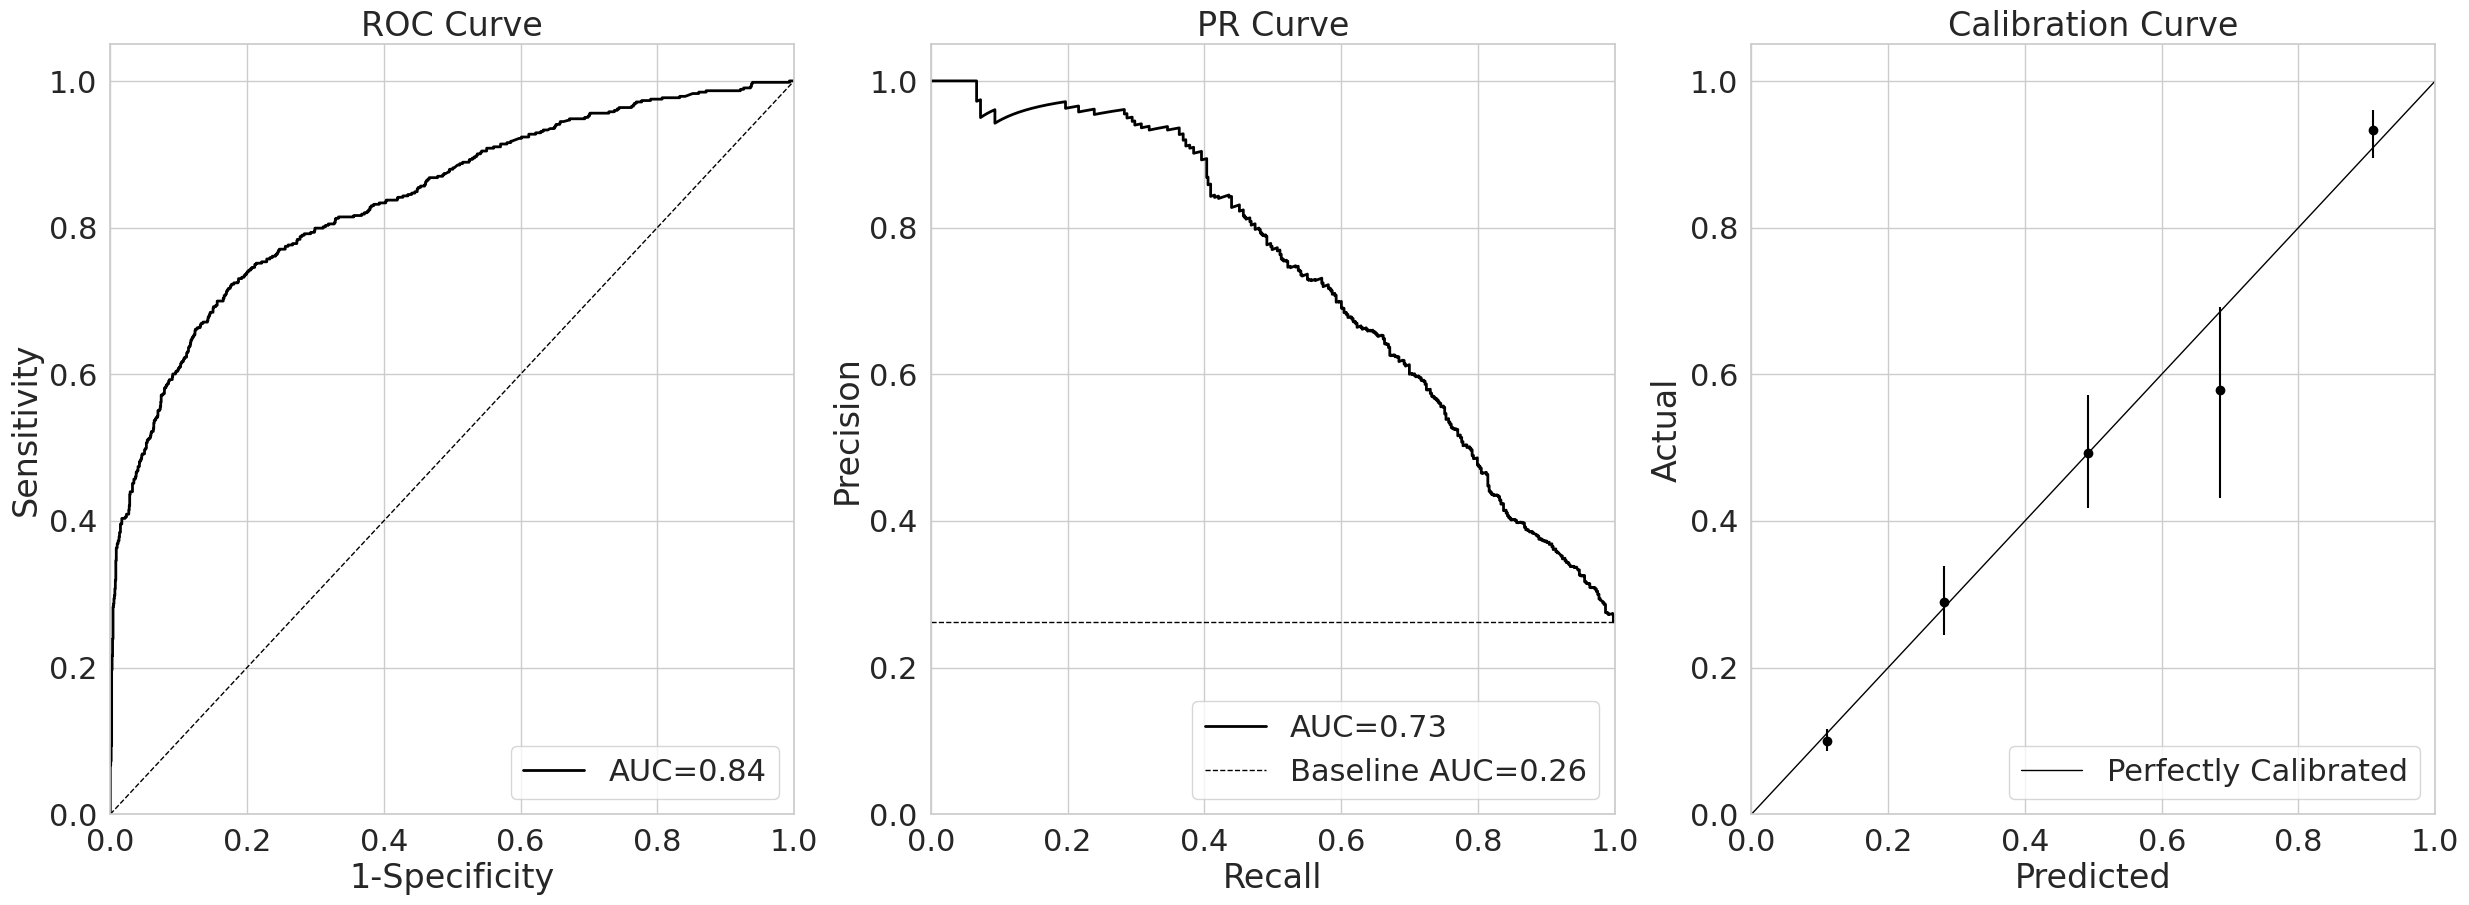

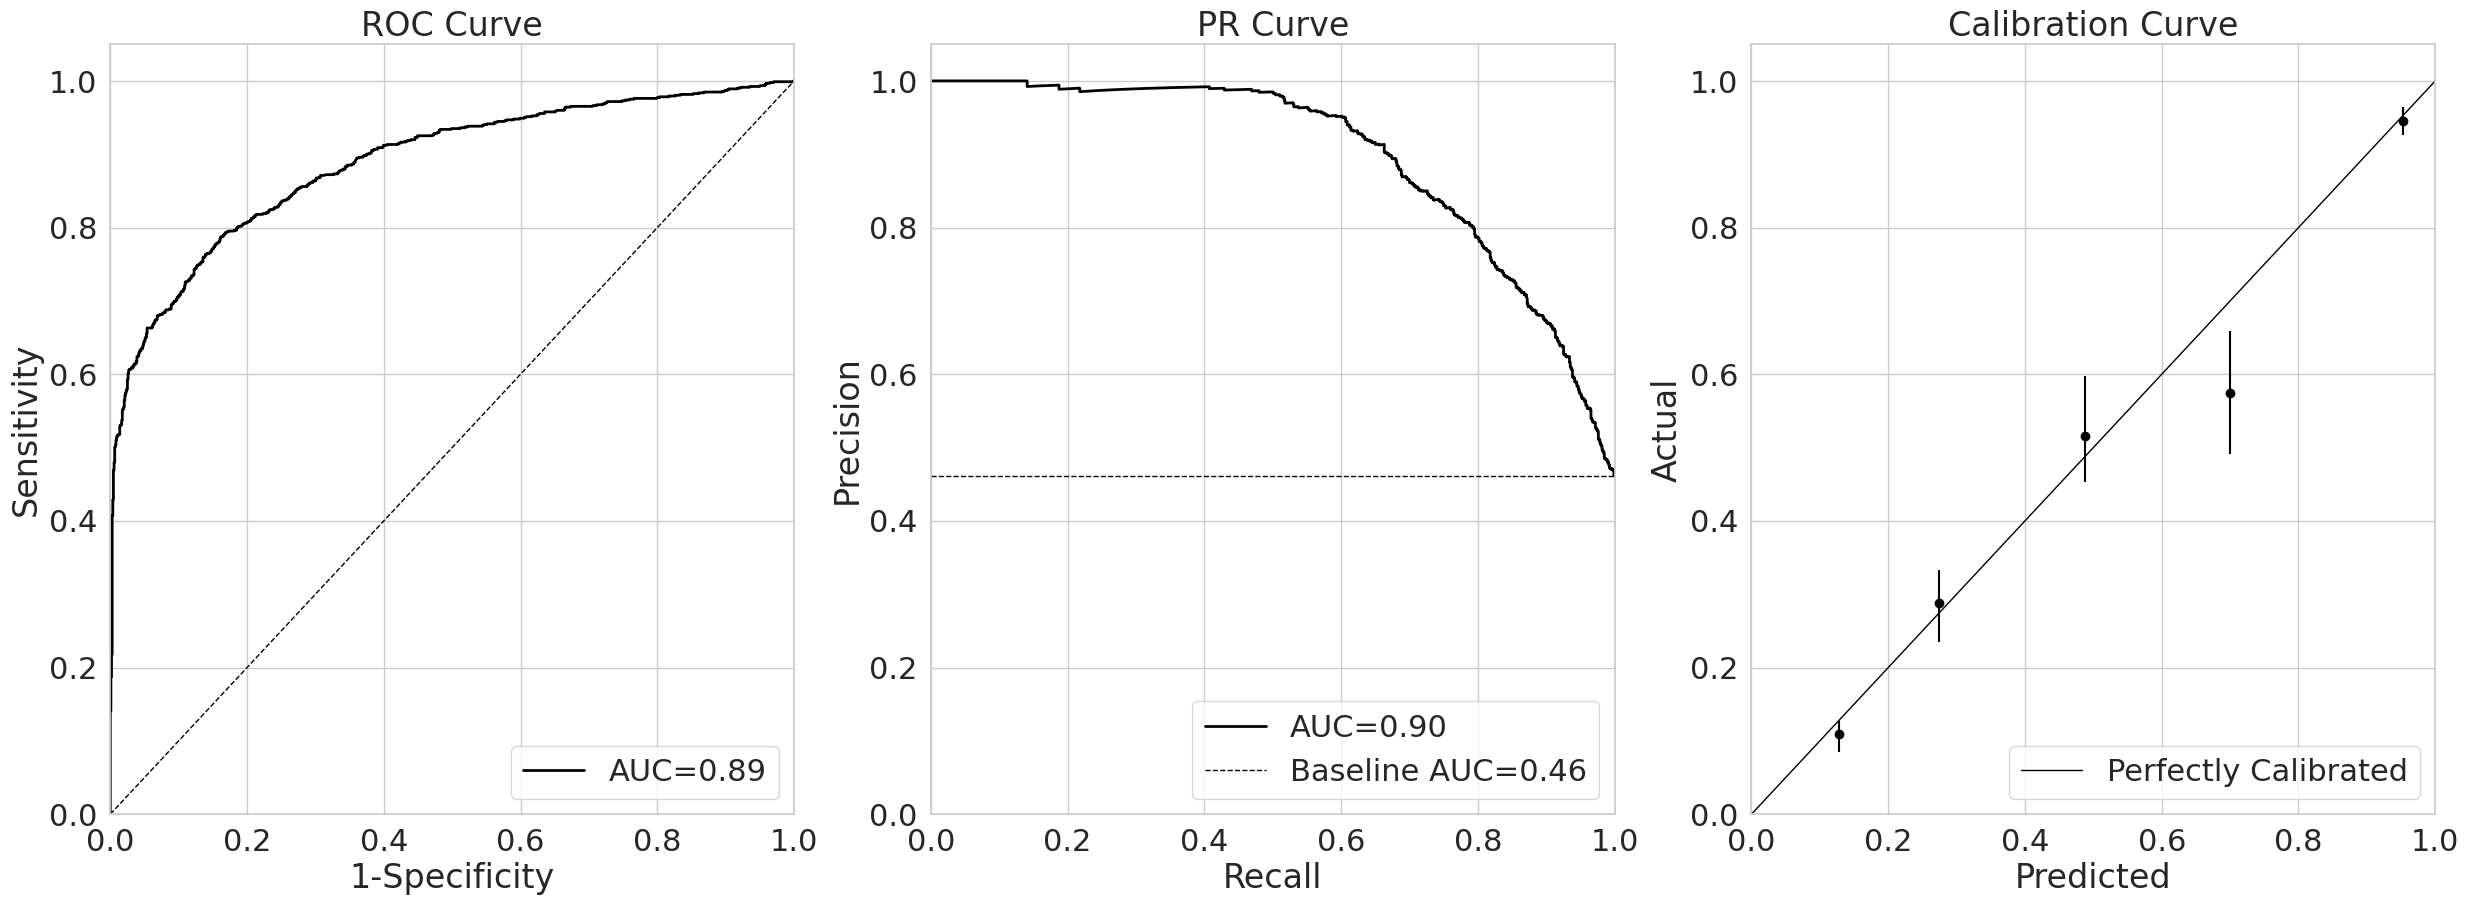

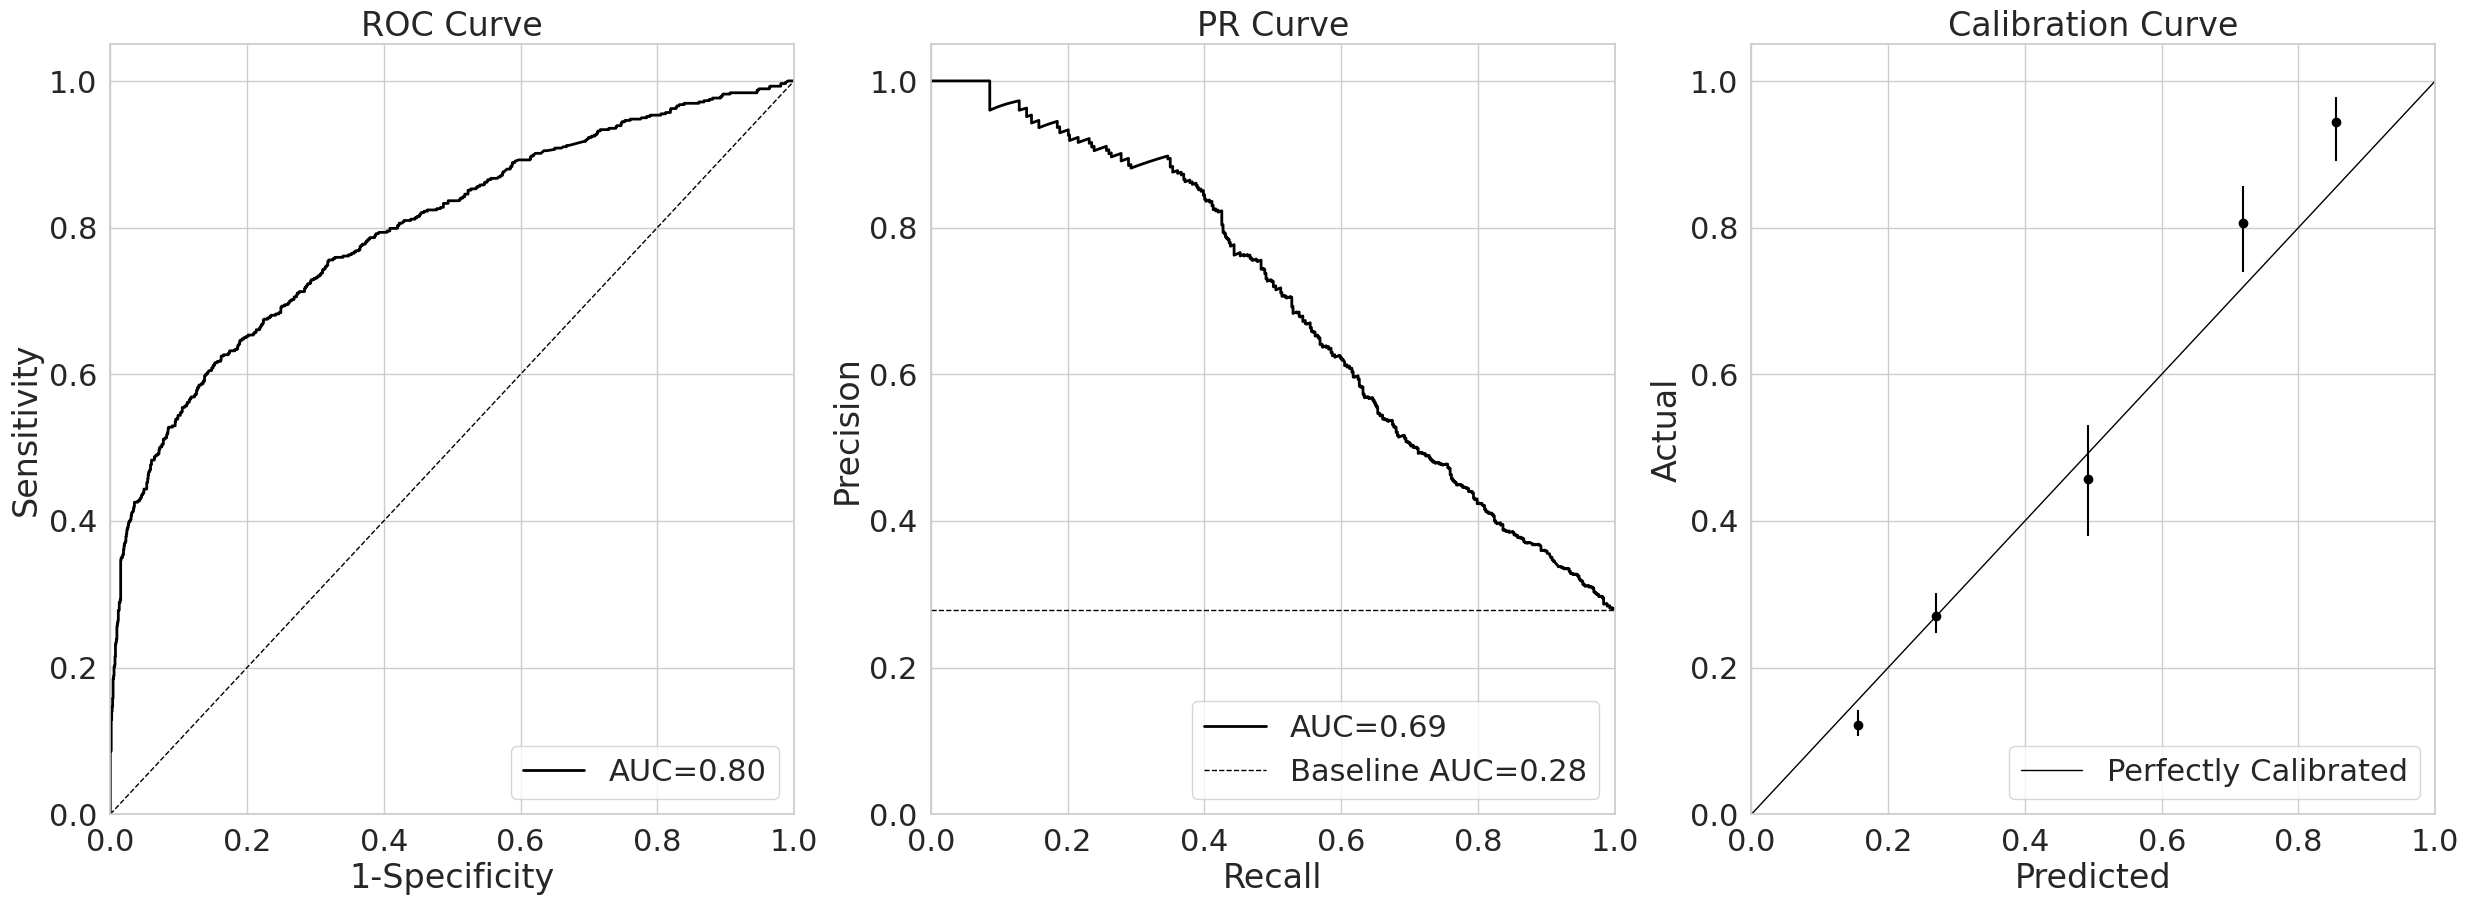

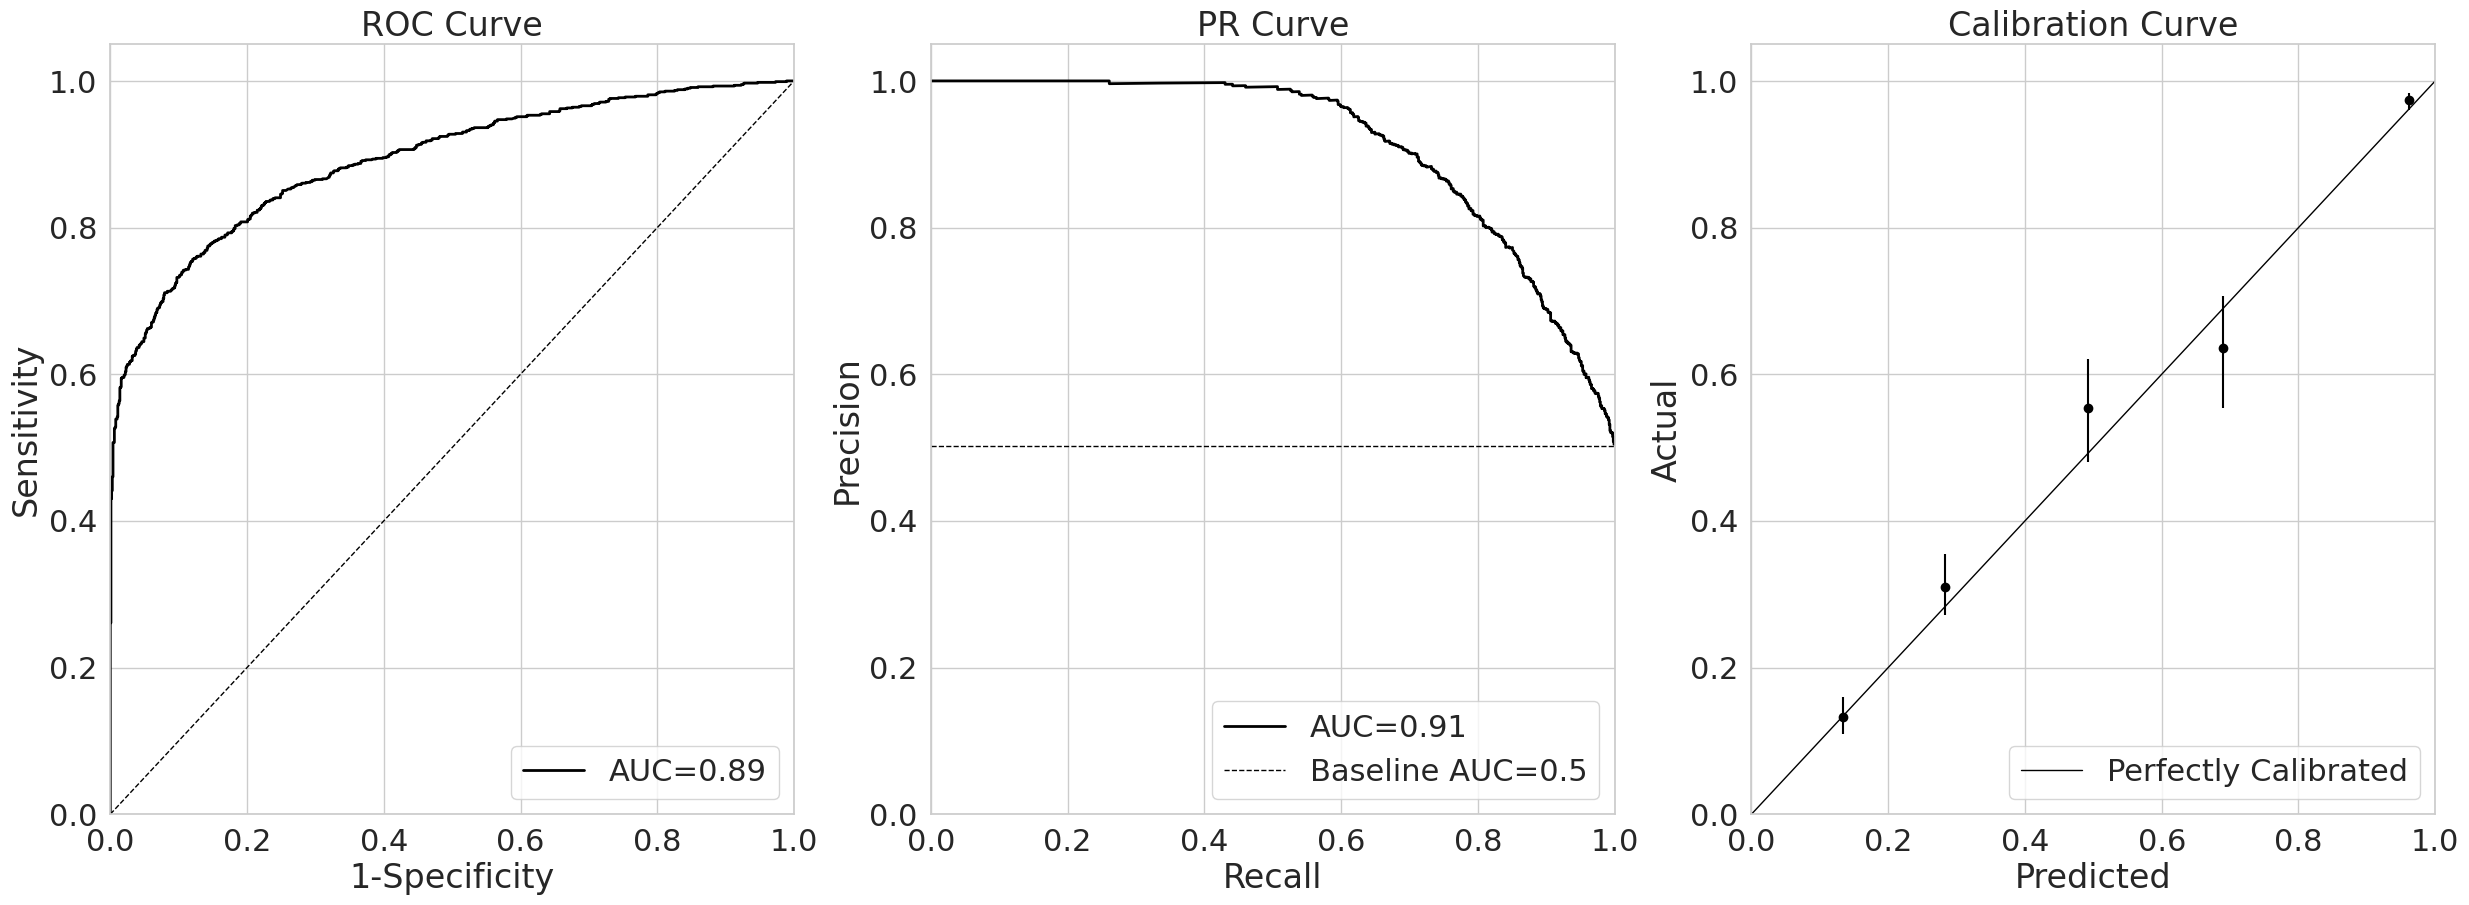

In [11]:
from healthrex_ml.evaluators import BinaryEvaluator
from tqdm import tqdm

for task in tqdm(tasks):
    evalr = BinaryEvaluator(
        outdir=f"./{RUN_NAME}_artifacts/{task}_performance_artificats/",
        task_name=task
    )
    df_yhats = pd.read_csv(os.path.join(trainer.working_dir, f"{task}_yhats.csv"))
    evalr(df_yhats.labels, df_yhats.predictions)